# LSTM Time Series Modeling
In this notebook, I will be building Long Short-Term Memory neural networks. These neural networks are a type of Recurrent Neural Network that is particularly adept at recalling past data and determining how much information is useful or not useful for making predictions.

##### Disclaimer: This notebook should not be considered any kind of financial advice. It exists only for the purposes of practicing modeling and making predictions

In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import xgboost
from xgboost import XGBClassifier

import datetime as dt

# New import of my custom class
from classification_classes import Model
from spider_classes import Materials, Energy, Financials, Industrials, Technology, Staples, Utilities, Health, \
Consumer, Real_Estate, Communication_Services
from other_functions import compare_curves

pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 35)
sns.set_style("dark")

import warnings

# Suppress FutureWarnings for all of scikit-learn's modules
warnings.filterwarnings("ignore")

import pickle

In [276]:
# New imports
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from scikeras.wrappers import KerasRegressor


<hr style="border: 2px solid blue">

### Functions

In [341]:
def test_metric_check(model, y_test=y_test, test_data=X_test):
    """
    Displays the RMSE, MSE, and R-Squared of a model on test data
    """
    y_preds = model.predict(test_data)
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_preds)), "MAE:", mean_absolute_error(y_test, y_preds),\
          "R-Squared:", r2_score(y_test, y_preds))

In [373]:
# Plotting Function

def plot_results(model, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test):
    """
    Plot the predictions vs reality for train, validation, and test data.
    Requires the model and three feature samples
    
    """
    train_preds = model.predict(X_train).flatten()
    val_preds = model.predict(X_val).flatten()
    y_preds = model.predict(X_test).flatten()

    fig, ax = plt.subplots(nrows=3, figsize=(16,24))
    # plotting the training data

    ax[0].plot(list(price.index[:split_train]), train_preds, alpha = .5, linestyle=":")
    ax[0].plot(list(price.index[:split_train]), y_train, alpha = .5)
    ax[0].legend(["Predictions", "Training Data"])
    ax[0].set_title("Predictions on the Training Data");

    # plotting the validation data

    ax[1].plot(list(price.index[split_train:split_val]), val_preds, alpha = .5, linestyle=":")
    ax[1].plot(list(price.index[split_train:split_val]),y_val, alpha = .5)
    ax[1].legend(["Predictions", "Validation Data"])
    ax[1].set_title("Validation Data and Predictions");

    # plotting the test data

    ax[2].plot(list(price.index[split_val:]), y_preds, alpha=.5, linestyle=":")
    ax[2].plot(list(price.index[split_val:]), y_test, alpha=.5)
    ax[2].legend(["Predictions", "Reality"])
    ax[2].set_title("Test Data - Furthest Removed from Training");


    # 2nd plot with all the charts concatenated
    fig, ax = plt.subplots(figsize=(16,10))
    ax.plot(list(price.index[:split_train]), train_preds, alpha = .5, linestyle=":")
    ax.plot(list(price.index[:split_train]), y_train, alpha = .5, linestyle="--")


    ax.plot(list(price.index[split_train:split_val]), val_preds, alpha = .5, linestyle=":")
    ax.plot(list(price.index[split_train:split_val]), y_val, alpha = .5, linestyle="--")


    ax.plot(list(price.index[split_val:]), y_preds, linestyle=":", alpha=.5)
    ax.plot(list(price.index[split_val:]), y_test, alpha=.5)
    ax.legend(["Predictions", "Reality"])



    ax.legend(["Predictions", "Training Data", "Val Predictions", "Validation Data",\
                "Test Predictions", "Test Data"])
    ax.set_xlim(9000, 19500)
    ax.set_title("Training, Validation, and Test Predictions")
    ax.axvline(15030, linestyle=":")
    ax.axvline(17156, linestyle=":");

### Container for model metrics

In [311]:
metric_df = pd.DataFrame(columns=["Name", "Train MAE", "Train MSE", 'Train RMSE', 'Train MAPE', 'Train R^2',\
                                 "Val MAE", "Val MSE", 'Val RMSE', 'Val MAPE', 'Val R^2', "Test MAE", "Test MSE", \
                                  'Test RMSE', 'Test MAPE', 'Test R^2'])

In [339]:
def aggregate_model_stats(name, model, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, \
                          y_val=y_val, y_test=y_test):
    """
    Adds model performance data to an existing dataframe object
    """
    
    train_preds = model.predict(X_train).flatten()
    val_preds = model.predict(X_val).flatten()
    y_preds = model.predict(X_test).flatten()

    # training metrics
    train_mae = mean_absolute_error(y_train, train_preds)
    train_mse = mean_squared_error(y_train, train_preds)
    train_rmse = mean_squared_error(y_train, train_preds, squared=False)
    train_mape = mean_absolute_percentage_error(y_train, train_preds)
    train_r2 = r2_score(y_train, train_preds)
    
    # val metrics
    val_mae = mean_absolute_error(y_val, val_preds)
    val_mse = mean_squared_error(y_val, val_preds)
    val_rmse = mean_squared_error(y_val, val_preds, squared=False)
    val_mape = mean_absolute_percentage_error(y_val, val_preds)
    val_r2 = r2_score(y_val, val_preds)
    
    # test metrics
    test_mae = mean_absolute_error(y_test, y_preds)
    test_mse = mean_squared_error(y_test, y_preds)
    test_rmse = mean_squared_error(y_test, y_preds, squared=False)
    test_mape = mean_absolute_percentage_error(y_test, y_preds)
    test_r2 = r2_score(y_test, y_preds)
    
    metric_dict = {"Name": name, "Train MAE":train_mae, "Train MSE":train_mse, "Train RMSE":train_rmse, \
                  "Train MAPE":train_mape, "Train R^2": train_r2, "Val MAE":val_mae, "Val MSE":val_mse,\
                   "Val RMSE":val_rmse, "Val MAPE":val_mape, "Val R^2": val_r2, "Test MAE":test_mae, \
                   "Test MSE":test_mse, "Test RMSE":test_rmse, "Test MAPE":test_mape, "Test R^2": test_r2}
    metric_df.loc[len(metric_df)] = metric_dict
    

<hr style="border: 2px solid blue">

# Data

In [49]:
# Load the S&P Data
df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/INDICES_FILLED.csv')
df.head(2)

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,GDP_Filled,Interest_Rates,Mkt-RF,SMB,HML,RMW,CMA,garman_klass_vol,RSI,...,dollar_volume(M),Quarter,Month,cycle_year,day_of_week,one_months_later,three_months_later,six_months_later,twelve_months_later,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change,One_Month_Positive,Three_Month_Positive,Six_Month_Positive,Twelve_Month_Positive
0,1964-02-06,^GSPC,76.93,76.93,77.260002,76.470001,0.0,4110000.0,669.822,3.50,0.0024,0.0006,-0.0023,0.0004,0.0006,NaN,64.329769,...,316.1823,1,2,4,Thursday,1964-03-06,1964-05-06,1964-08-06,1965-02-08,0.017938,0.053685,0.057325,0.130248,1.0,1.0,1.0,1.0
1,1964-02-07,^GSPC,77.18,77.18,77.510002,76.660004,0.0,4710000.0,669.822,3.52,0.0037,-0.0006,0.0014,0.0008,0.0036,NaN,68.197375,...,363.5178,1,2,4,Friday,1964-03-09,1964-05-07,1964-08-07,1965-02-08,0.014900,0.051438,0.060637,0.126587,1.0,1.0,1.0,1.0


In [50]:
# Prepare the dataframe appropriately
df['Date'] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df["Quarter"] = df["Quarter"].astype(str)
df['Month'] = df['Month'].astype(str)
df['cycle_year'] = df['cycle_year'].astype(str)
# Isolate S&P 500 index
df = df[df['Ticker'] == "^GSPC"]

In [51]:
df.shape

(14634, 40)

### Preparation for LSTM Neural Network - Univariate Modeling

In [52]:
# Establishing price as the only variable

price = df[["Adj Close"]]

In [54]:
# Using the .shift() method to create feature columns for previous prices

price["1_Day_Ago"] = price["Adj Close"].shift(1)
price["2_Day_Ago"] = price["Adj Close"].shift(2)
price["3_Day_Ago"] = price["Adj Close"].shift(3)
price["4_Day_Ago"] = price["Adj Close"].shift(4)
price["5_Day_Ago"] = price["Adj Close"].shift(5)
price["6_Day_Ago"] = price["Adj Close"].shift(6)
price["7_Day_Ago"] = price["Adj Close"].shift(7)
price["8_Day_Ago"] = price["Adj Close"].shift(8)
price["9_Day_Ago"] = price["Adj Close"].shift(9)
price["10_Day_Ago"] = price["Adj Close"].shift(10)
price["11_Day_Ago"] = price["Adj Close"].shift(11)
price["12_Day_Ago"] = price["Adj Close"].shift(12)
price["13_Day_Ago"] = price["Adj Close"].shift(13)
price["14_Day_Ago"] = price["Adj Close"].shift(14)
price["15_Day_Ago"] = price["Adj Close"].shift(15)

In [55]:
# Inspecting the price data - verifying nulls end after 15 days worth of data
price[:16]

,Adj Close,1_Day_Ago,2_Day_Ago,3_Day_Ago,4_Day_Ago,5_Day_Ago,6_Day_Ago,7_Day_Ago,8_Day_Ago,9_Day_Ago,10_Day_Ago,11_Day_Ago,12_Day_Ago,13_Day_Ago,14_Day_Ago,15_Day_Ago
Date,,,,,,,,,,,,,,,,
1964-02-06,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-07,77.180000,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-10,77.050003,77.180000,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-11,77.330002,77.050003,77.180000,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-13,77.519997,77.330002,77.050003,77.180000,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-14,77.480003,77.519997,77.330002,77.050003,77.180000,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-17,77.459999,77.480003,77.519997,77.330002,77.050003,77.180000,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-18,77.470001,77.459999,77.480003,77.519997,77.330002,77.050003,77.180000,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-19,77.550003,77.470001,77.459999,77.480003,77.519997,77.330002,77.050003,77.180000,76.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dropping first 15 days of the data to avoid nulls

In [56]:
# Drop the nulls
price.dropna(inplace=True)

# Identify a split point for plotting purposes
split_pt = int(len(price) * .85)
train = price[:split_pt]
test = price[split_pt:]

# X data and Y data, then split by dates

In [74]:
# splitting the data between target and features

X = np.array(price.drop(columns=["Adj Close"]))
y = np.array(price["Adj Close"])

In [75]:
# qualities of the features
X.shape, type(X)

((14619, 15), numpy.ndarray)

In [76]:
# qualities of the target
y.shape, type(y)

((14619,), numpy.ndarray)

In [78]:
# Reshaping the data so that it is appropriate for the Neural Network
X = X.reshape(len(y), X.shape[1], 1)

In [79]:
X.shape

(14619, 15, 1)

### Splitting the data
I will split the data into training, validation, and then leave a final hold-out set for testing the model.

In [83]:
# Train on 80% test on Validate on 80-90, test on 90-100
split_train = int(len(y) *.80)
split_val = int(len(y) *.90)

# Splits
X_train, y_train = X[:split_train], y[:split_train]
X_val, y_val = X[split_train:split_val], y[split_train:split_val]
X_test, y_test = X[split_val:], y[split_val:]

In [84]:
# Verifying compatability
X_train.shape, y_train.shape

(11695, 15, 1)

<hr style="border: 4px solid green"> 

### LSTM Model
Here, I use keras and tensorflow to create a Long Short-Term Memory Neural network. LSTM neural networks are a type of recurrent neural network (RNN) designed to model and predict sequential data by retaining past data, and deciding how much of it to encorporate in its predictions. It regulates information flow, enabling it to store and access information across varying time steps. The network's ability to selectively remember or forget information over extended sequences allows it to fit to patterns, making it especially effective for tasks involving time-series data. 

In [306]:
# Creating a basic LSTM model with several dense layers after initial LSTM layer

# Type of model
model1 = Sequential()

# LSTM Layer, arbitrarily used 50 nodes, input_shape = 15, 1: past observations of 1 feature
model1.add(LSTM(units=50, activation="tanh", input_shape=(15,1)))
model1.add(Dense(units=25, activation="relu"))
model1.add(Dense(units=12, activation="relu"))
model1.add(Dense(units=1))

model1.compile(loss="mean_squared_error", optimizer="adam", \
               metrics=["mean_absolute_error", 'mean_squared_error', \
                        'mean_absolute_percentage_error'])

model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=50)

Epoch 1/10
234/234 [==============================] - 4s 10ms/step - loss: 397369.0938 - mean_absolute_error: 434.5006 - mean_squared_error: 397369.0938 - mean_absolute_percentage_error: 78.6773 - val_loss: 2251635.5000 - val_mean_absolute_error: 1464.0018 - val_mean_squared_error: 2251635.5000 - val_mean_absolute_percentage_error: 83.5476
Epoch 2/10
234/234 [==============================] - 2s 9ms/step - loss: 113685.7344 - mean_absolute_error: 174.6941 - mean_squared_error: 113685.7344 - mean_absolute_percentage_error: 18.5302 - val_loss: 687847.1250 - val_mean_absolute_error: 761.4008 - val_mean_squared_error: 687847.1250 - val_mean_absolute_percentage_error: 41.5457
Epoch 3/10
234/234 [==============================] - 2s 9ms/step - loss: 7806.4341 - mean_absolute_error: 41.0560 - mean_squared_error: 7806.4341 - mean_absolute_percentage_error: 5.9982 - val_loss: 320993.9688 - val_mean_absolute_error: 471.5605 - val_mean_squared_error: 320993.9688 - val_mean_absolute_percentage_err

In [320]:
# add data to the dataframe container

aggregate_model_stats("First LSTM", model1, X_train, X_val, X_test, y_train, y_val, y_test)
metric_df

,Name,Train MAE,Train MSE,Train RMSE,Train MAPE,Train R^2,Val MAE,Val MSE,Val RMSE,Val MAPE,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,First LSTM,14.655849,692.004735,26.305983,0.029581,0.996893,331.236827,175497.96775,418.924776,0.16868,-0.619916,1756.5862,3.592956e+06,1895.509464,0.517191,-5.948278


### Train predictions
These predictions are quite exceptional, especially when considering the extreme volatility in 2000 and 2008. With patterns as random as these, I would think that it will be difficult to generalize predictions going forward. These plots will be shown one at a time for now, but in the future they will be shown all at once.

366/366 [==============================] - 1s 3ms/step


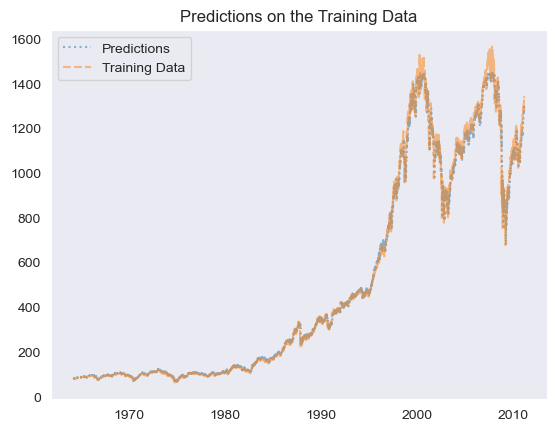

In [321]:
# Plotting the model on training data

# flattening the predictions into a array/vector
train_preds = model1.predict(X_train).flatten()

# plotting the predictions
plt.plot(list(price.index[:split_train]), train_preds, alpha = .5, linestyle=":")

# plotting the true training values
plt.plot(list(price.index[:split_train]), y_train, alpha = .5, linestyle="--")

# legend and title
plt.legend(["Predictions", "Training Data"])
plt.title("Predictions on the Training Data");

### Validation Predictions
The LSTM model does a reasonably good job of predicting values for about 18 months after the training data ended, albeit on a big of a lag. Then, the model loses all signal and begins to disappoint.

46/46 [==============================] - 0s 2ms/step


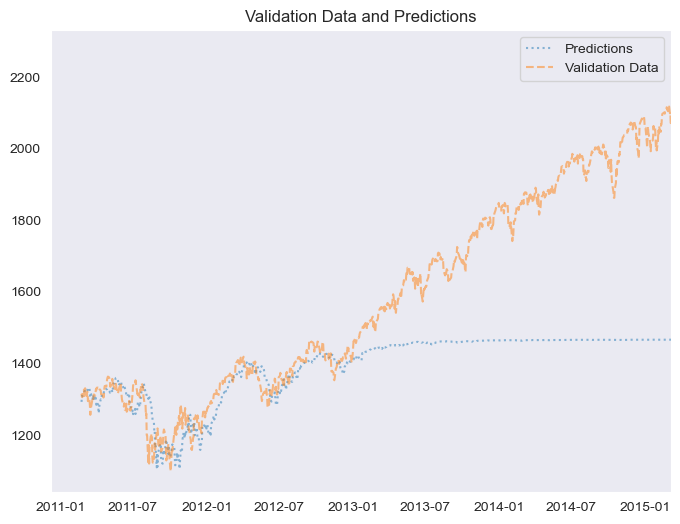

In [325]:
# Plotting the validation data

fig, ax = plt.subplots(figsize=(8,6))

# flattening the val preds into an array/vector 
val_preds = model1.predict(X_val).flatten()

# plotting val preds
ax.plot(list(price.index[split_train:split_val]), val_preds, alpha = .5, linestyle=":")

# plotting true validation values
ax.plot(list(price.index[split_train:split_val]),y_val, alpha = .5, linestyle="--")

# Title, legend, zooming in to see the moment of divergence
ax.legend(["Predictions", "Validation Data"])
ax.set_xlim(14950, 16500)
ax.set_title("Validation Data and Predictions");

### Test Predictions
These are overall very poor results. The training data had expired several years ago, and the model no longer had a grasp on what appropriate output values should look like.

46/46 [==============================] - 0s 2ms/step


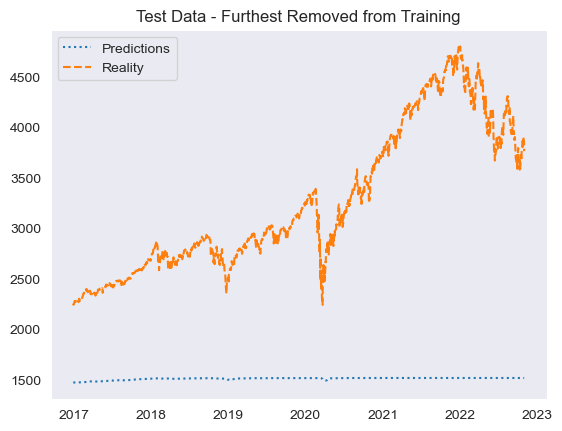

In [324]:
# Plotting test data

# Turn the predictions into an array/vector
y_preds = model1.predict(X_test).flatten()
# plot the predictions
plt.plot(list(price.index[split_val:]), y_preds, linestyle=":")
# plot the true values of the test data
plt.plot(list(price.index[split_val:]), y_test, linestyle="--")
plt.legend(["Predictions", "Reality"])
plt.title("Test Data - Furthest Removed from Training");

### All sections together
The further away in time that we get from the training data, the more unreliable the predictions become. 

46/46 [==============================] - 0s 3ms/step


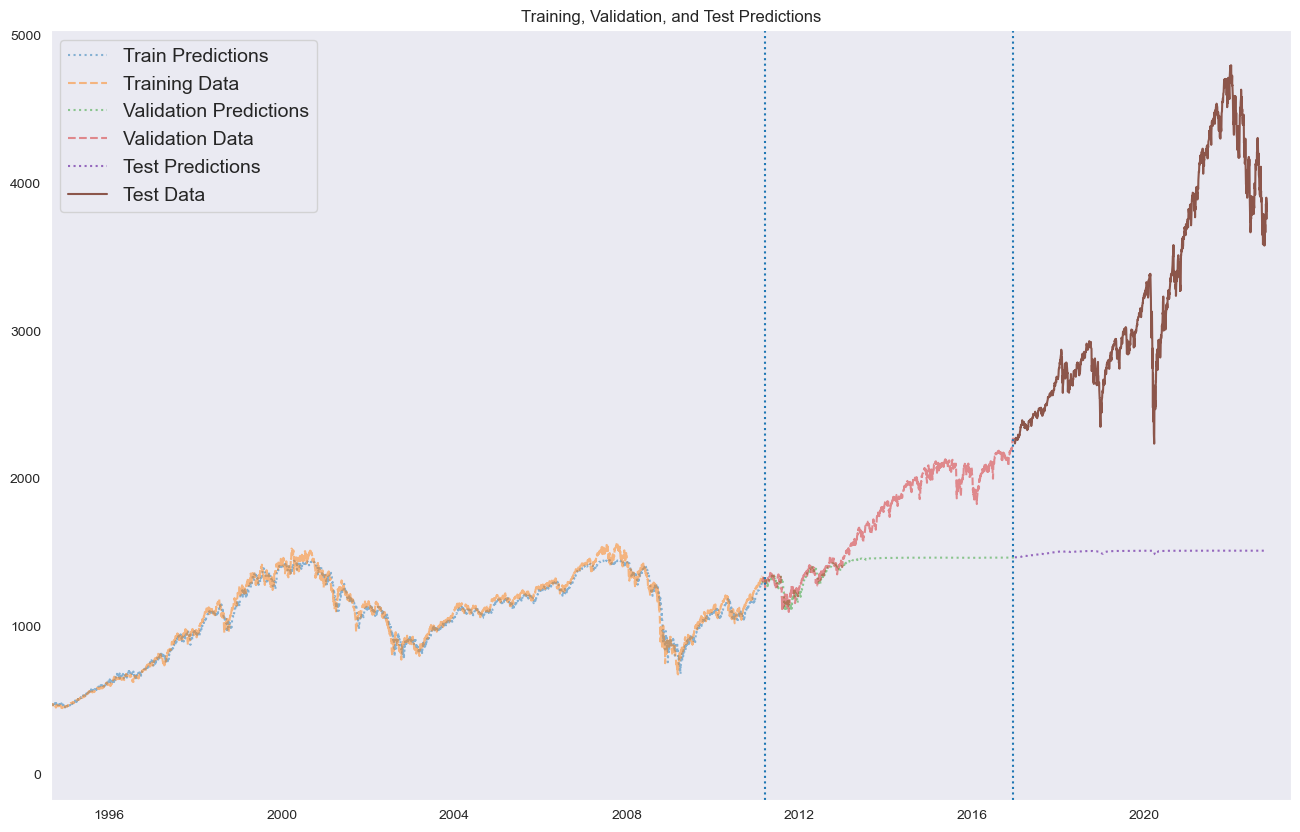

In [370]:
# Plotting the totality of the data, this is how future plots will look as well

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(list(price.index[:split_train]), train_preds, alpha = .5, linestyle=":")
ax.plot(list(price.index[:split_train]), y_train, alpha = .5, linestyle="--")


ax.plot(list(price.index[split_train:split_val]), val_preds, alpha = .5, linestyle=":")
ax.plot(list(price.index[split_train:split_val]), y_val, alpha = .5, linestyle="--")


y_preds = model1.predict(X_test)
plt.plot(list(price.index[split_val:]), y_preds, linestyle=":")
plt.plot(list(price.index[split_val:]), y_test)
plt.legend(["Predictions", "Reality"])



plt.legend(["Train Predictions", "Training Data", "Validation Predictions", "Validation Data",\
            "Test Predictions", "Test Data"], fontsize= 14)
plt.xlim(9000, 19500)
plt.title("Training, Validation, and Test Predictions")
ax.axvline(15050, linestyle=":")
ax.axvline(17152, linestyle=":");

# Next Iteration
### Stacked LSTM
This version of the neural network uses two consecutive LSTM nodes. The key difference in the code is that we have to set "return_sequences" to True. This ensures that the correct input shape is given to the second layer of LSTM nodes. I will also use "TensorBoard" to log the results of this model and gain access to performance evaluation metrics.

In [335]:
# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir="logs")

In [336]:
# Define the model2

# Sequential type
model2 = Sequential()

# LSTM Layer
model2.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(15, 1)))

# 2nd/Stacked LSTM Layer
model2.add(LSTM(50, activation='relu'))

# Dense Output Layer
model2.add(Dense(1))

# Compile the model2
model2.compile(optimizer='adam', loss='mse')

# Fit it to the data
model2.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=tensorboard_callback, epochs=20, batch_size=50)

Epoch 1/20
234/234 [==============================] - 6s 17ms/step - loss: 15628.4922 - val_loss: 693.4852
Epoch 2/20
234/234 [==============================] - 4s 15ms/step - loss: 334.4713 - val_loss: 710.0029
Epoch 3/20
234/234 [==============================] - 4s 17ms/step - loss: 260.8059 - val_loss: 935.4852
Epoch 4/20
234/234 [==============================] - 4s 16ms/step - loss: 276.2391 - val_loss: 706.7536
Epoch 5/20
234/234 [==============================] - 4s 16ms/step - loss: 14819.3203 - val_loss: 1026.8939
Epoch 6/20
234/234 [==============================] - 4s 16ms/step - loss: 179.4542 - val_loss: 816.1446
Epoch 7/20
234/234 [==============================] - 3s 15ms/step - loss: 157.3861 - val_loss: 910.9944
Epoch 8/20
234/234 [==============================] - 3s 15ms/step - loss: 146.9469 - val_loss: 1122.7983
Epoch 9/20
234/234 [==============================] - 3s 15ms/step - loss: 139.5573 - val_loss: 566.1725
Epoch 10/20
234/234 [============================

In [337]:
# Store performance metrics in the container
aggregate_model_stats("Stacked LSTM", model2, X_train, X_val, X_test, y_train, y_val, y_test)
metric_df

46/46 [==============================] - 0s 4ms/step


,Name,Train MAE,Train MSE,Train RMSE,Train MAPE,Train R^2,Val MAE,Val MSE,Val RMSE,Val MAPE,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,First LSTM,14.655849,692.004735,26.305983,0.029581,0.996893,331.236827,175497.96775,418.924776,0.168680,-0.619916,1756.586200,3.592956e+06,1895.509464,0.517191,-5.948278
1,Stacked LSTM,6.905430,122.596246,11.072319,0.020250,0.999449,31.027961,1480.78129,38.480921,0.017092,0.986332,142.726357,2.498669e+04,158.071773,0.042615,0.951679


46/46 [==============================] - 0s 4ms/step


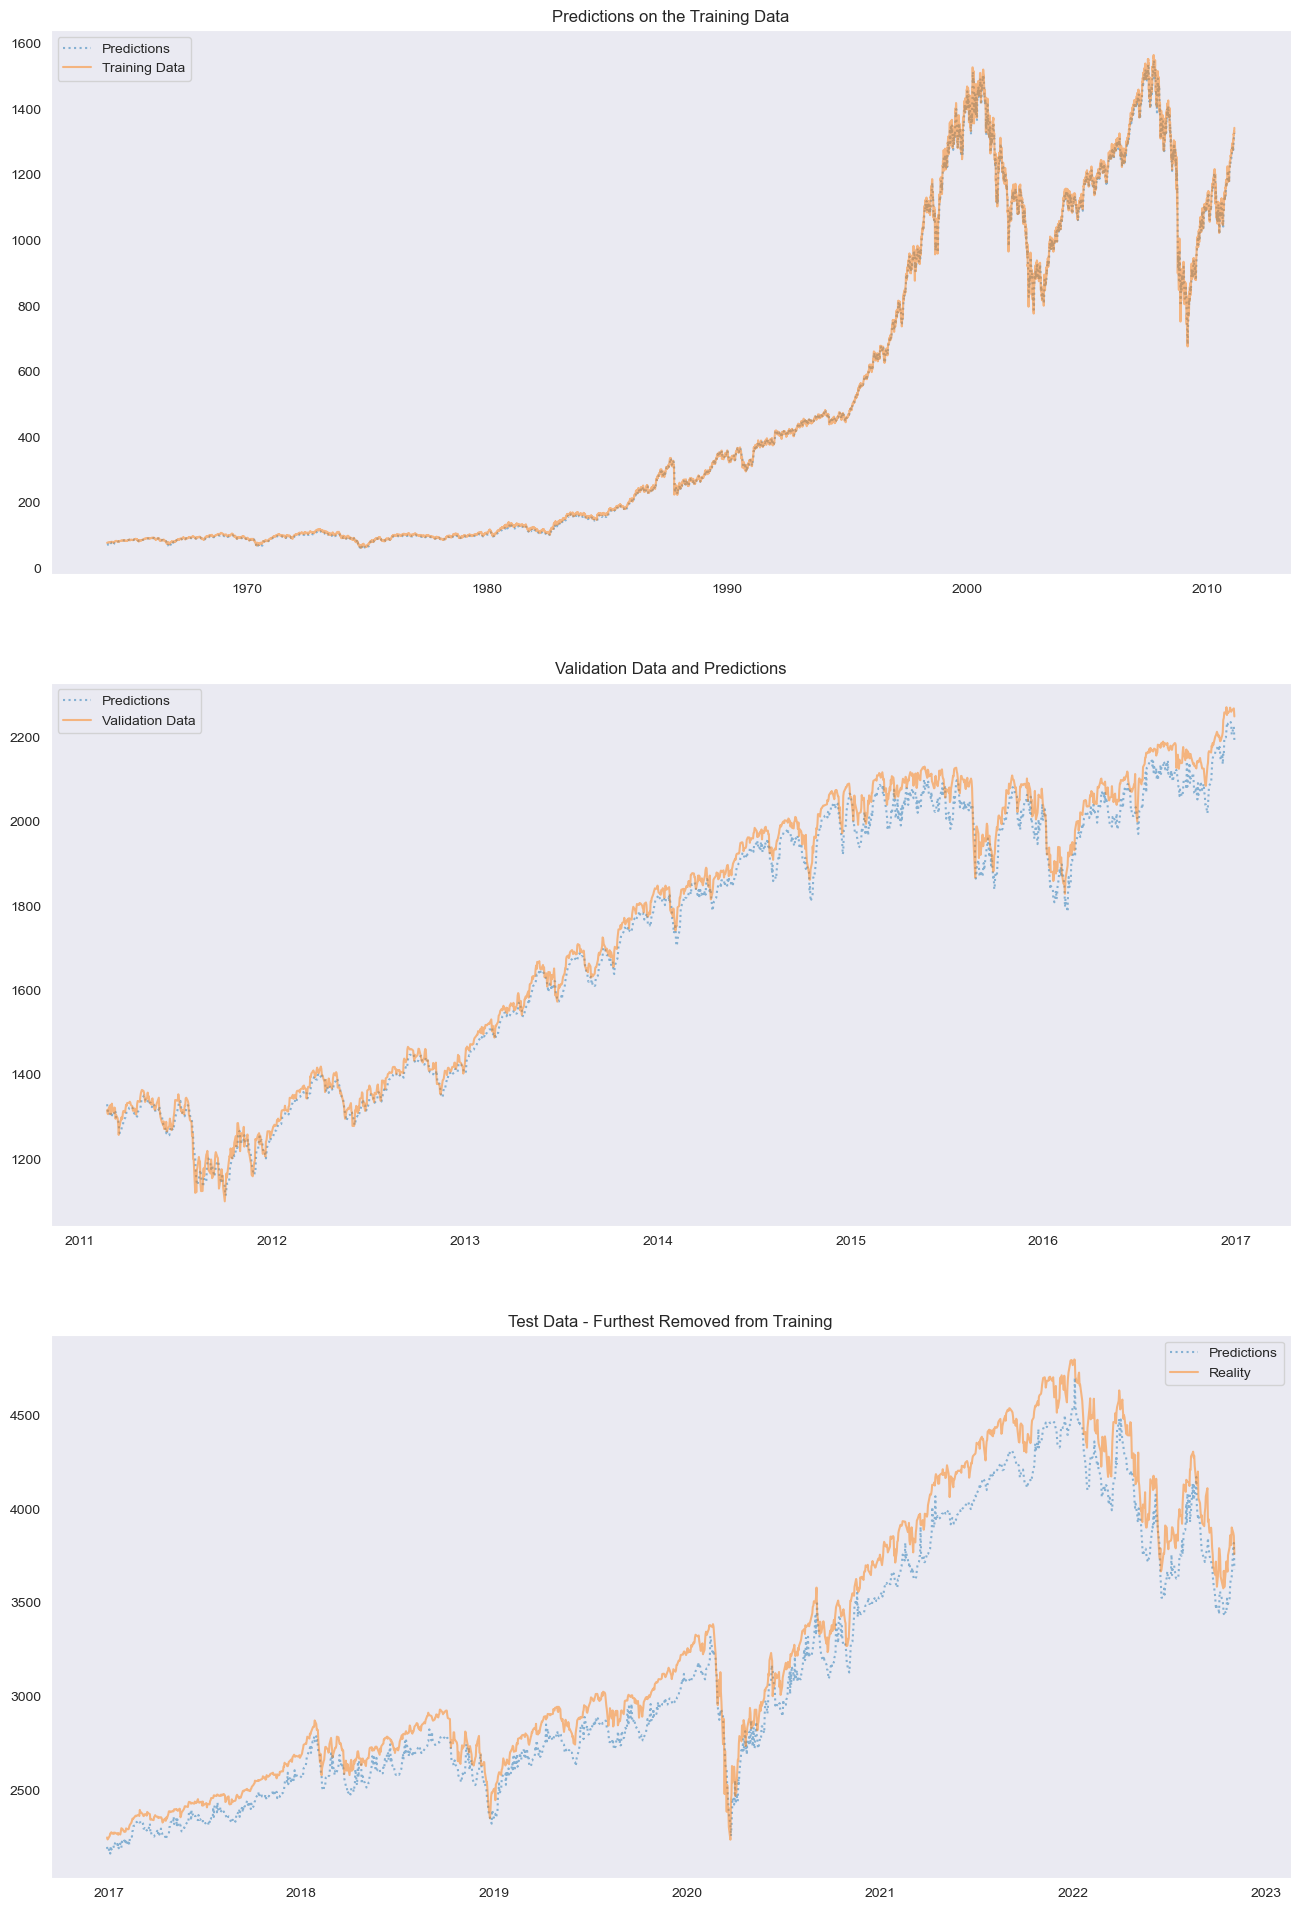

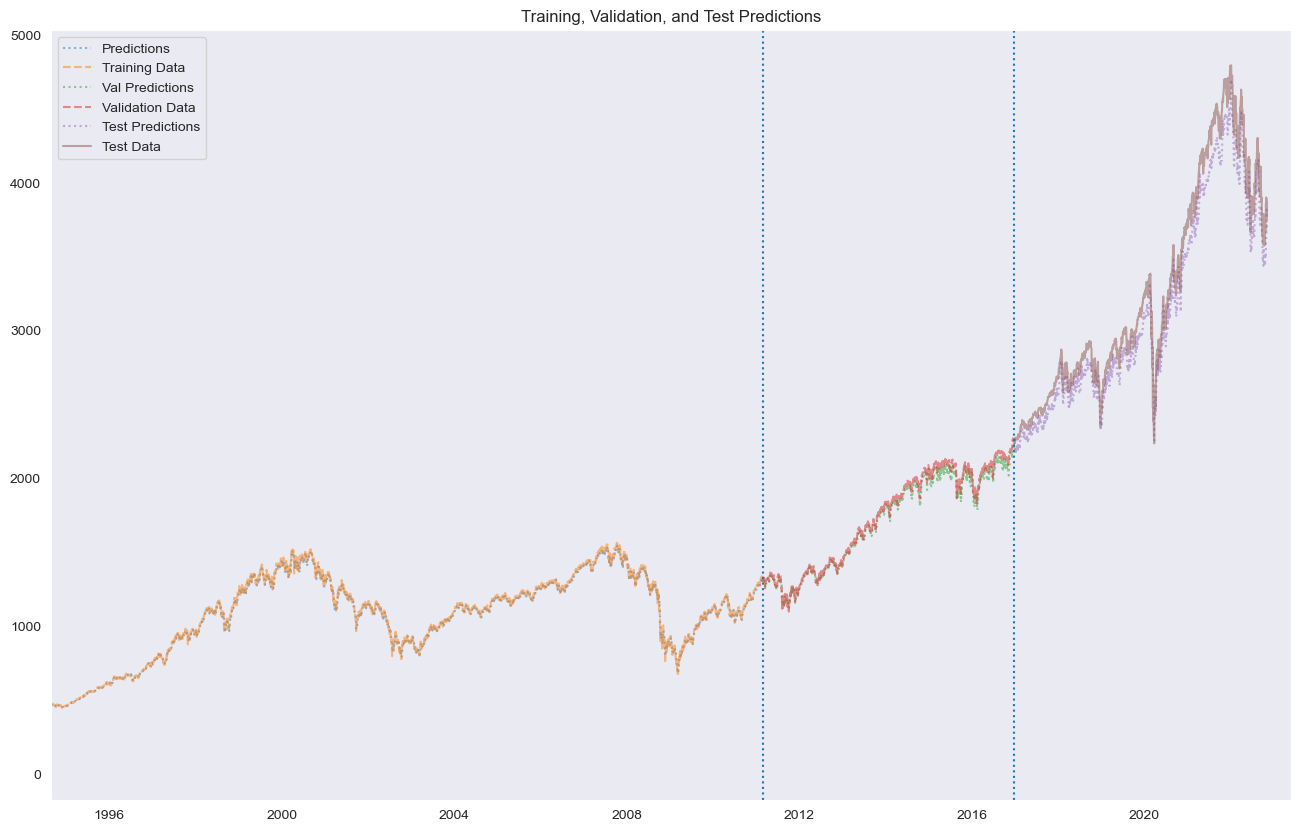

In [374]:
# Plot predictions vs true values 

plot_results(model2)

46/46 [==============================] - 0s 4ms/step


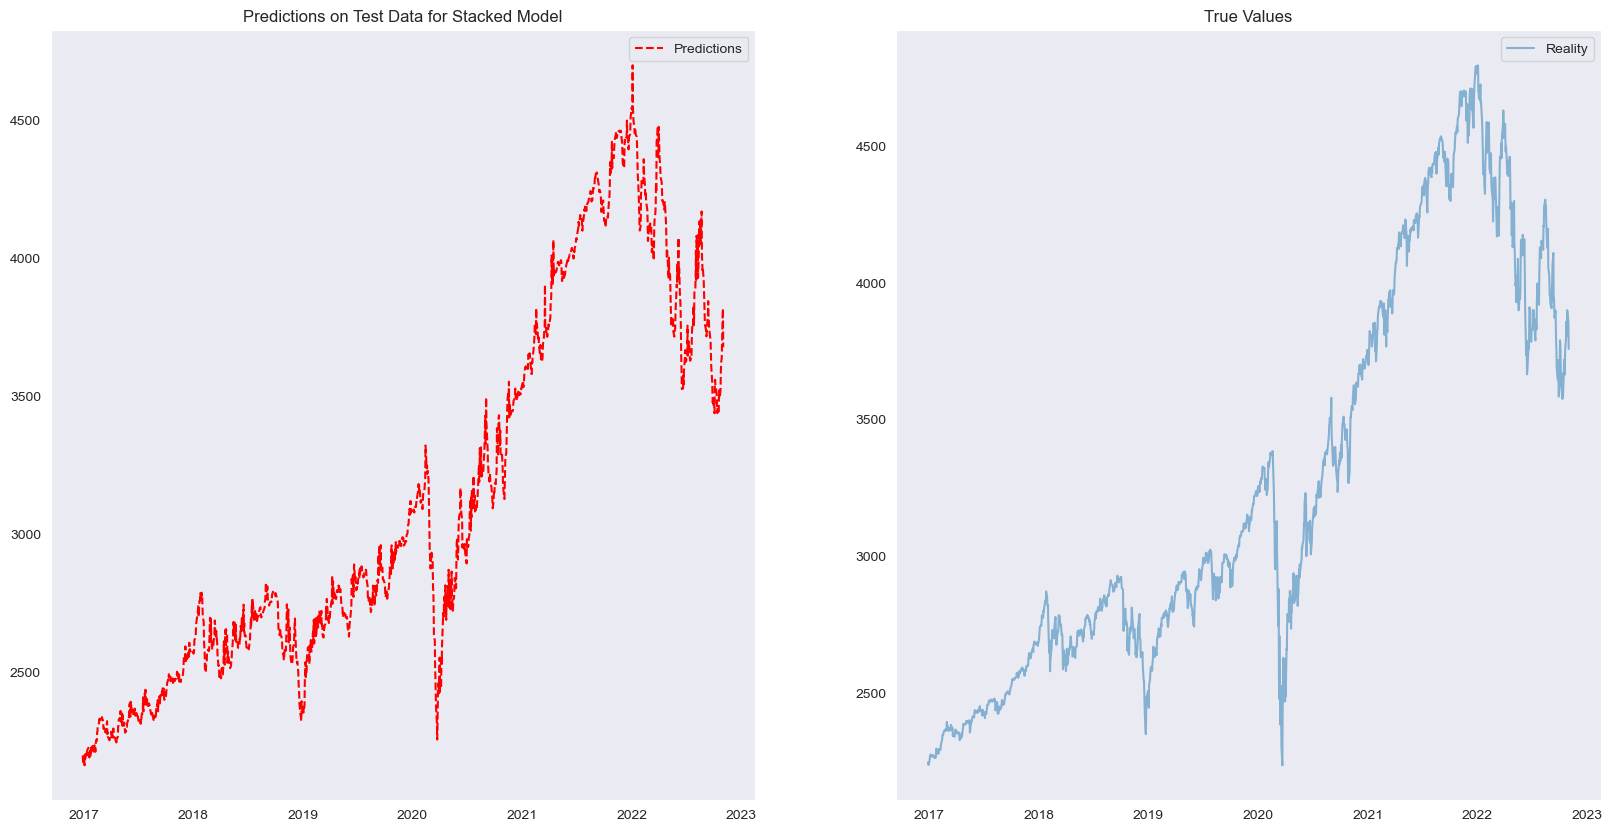

In [340]:
# Isolating the test values for direct comparison of predictions and true values

y_preds = model2.predict(X_test)
# Plotting the test data predictions vs reality, very impressive
fig, ax = plt.subplots(ncols=2, figsize = (20,10))
ax[0].plot(list(price.index[split_val:]), y_preds, linestyle="--", color="red")
ax[0].legend(["Predictions", "Reality"])
ax[0].set_title("Predictions on Test Data for Stacked Model")
ax[1].plot(list(price.index[split_val:]), y_test, alpha=.5)
ax[1].set_title("True Values")
ax[1].legend(["Reality"]);

### Metrics Check

In [342]:
# printing key metrics
test_metric_check(model2)

46/46 [==============================] - 0s 4ms/step
RMSE: 158.07177292107772 MAE: 142.72635710125257 R-Squared: 0.9516792210327737


In [343]:
# displaying the full data container
metric_df

,Name,Train MAE,Train MSE,Train RMSE,Train MAPE,Train R^2,Val MAE,Val MSE,Val RMSE,Val MAPE,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,First LSTM,14.655849,692.004735,26.305983,0.029581,0.996893,331.236827,175497.96775,418.924776,0.168680,-0.619916,1756.586200,3.592956e+06,1895.509464,0.517191,-5.948278
1,Stacked LSTM,6.905430,122.596246,11.072319,0.020250,0.999449,31.027961,1480.78129,38.480921,0.017092,0.986332,142.726357,2.498669e+04,158.071773,0.042615,0.951679


### Evaluation
Wow, this is quite an improvement. Adding a second LSTM layer and increasing the number of epochs by 2x has made the model's performance over a long stretch of time incredibly accurate. This was so impressive that I had to inspect it twice. Look at the above plot of the predicted test values in 2017-2023. That looks remarkably accurate. According to the metrics, 99% of variance in the data is explained by this neural network.

<hr style="border: 2pt solid blue">

### Re-running previous model with more epochs, but adding early stopping

In [344]:
# Adding in an early stopping callback
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1, 
                           patience=10,
                           mode='min')

In [345]:
# Define the model3

# Sequential type
model3 = Sequential()

# LSTM Layer
model3.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(15, 1)))

# 2nd/Stacked LSTM Layer
model3.add(LSTM(50, activation='relu'))

# Dense Output Layer
model3.add(Dense(1))

# Compile the model3
model3.compile(optimizer='adam', loss='mse')

# Fit it to the data
model3.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[tensorboard_callback, early_stop], epochs=100, batch_size=50)

Epoch 1/100
234/234 [==============================] - 6s 17ms/step - loss: 45366.8672 - val_loss: 569.4023
Epoch 2/100
234/234 [==============================] - 4s 16ms/step - loss: 152.5386 - val_loss: 449.6580
Epoch 3/100
234/234 [==============================] - 5s 22ms/step - loss: 154.9357 - val_loss: 500.6616
Epoch 4/100
234/234 [==============================] - 4s 17ms/step - loss: 134.4379 - val_loss: 907.4609
Epoch 5/100
234/234 [==============================] - 4s 17ms/step - loss: 122.5290 - val_loss: 597.7682
Epoch 6/100
234/234 [==============================] - 4s 17ms/step - loss: 147.5052 - val_loss: 425.0372
Epoch 7/100
234/234 [==============================] - 4s 17ms/step - loss: 136.2953 - val_loss: 489.4765
Epoch 8/100
234/234 [==============================] - 4s 16ms/step - loss: 134.9003 - val_loss: 361.9454
Epoch 9/100
234/234 [==============================] - 4s 15ms/step - loss: 140.9702 - val_loss: 541.9243
Epoch 10/100
234/234 [======================

In [346]:
# Adding data to the container
aggregate_model_stats("Stacked LSTM w Early Stopping", model3)
metric_df

46/46 [==============================] - 0s 4ms/step


,Name,Train MAE,Train MSE,Train RMSE,Train MAPE,Train R^2,Val MAE,Val MSE,Val RMSE,Val MAPE,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,First LSTM,14.655849,692.004735,26.305983,0.029581,0.996893,331.236827,175497.967750,418.924776,0.168680,-0.619916,1756.586200,3.592956e+06,1895.509464,0.517191,-5.948278
1,Stacked LSTM,6.905430,122.596246,11.072319,0.020250,0.999449,31.027961,1480.781290,38.480921,0.017092,0.986332,142.726357,2.498669e+04,158.071773,0.042615,0.951679
2,Stacked LSTM w Early Stopping,5.842786,109.315101,10.455386,0.013031,0.999509,17.368524,471.731029,21.719370,0.010204,0.995646,46.147017,3.600502e+03,60.004186,0.013905,0.993037


46/46 [==============================] - 0s 4ms/step


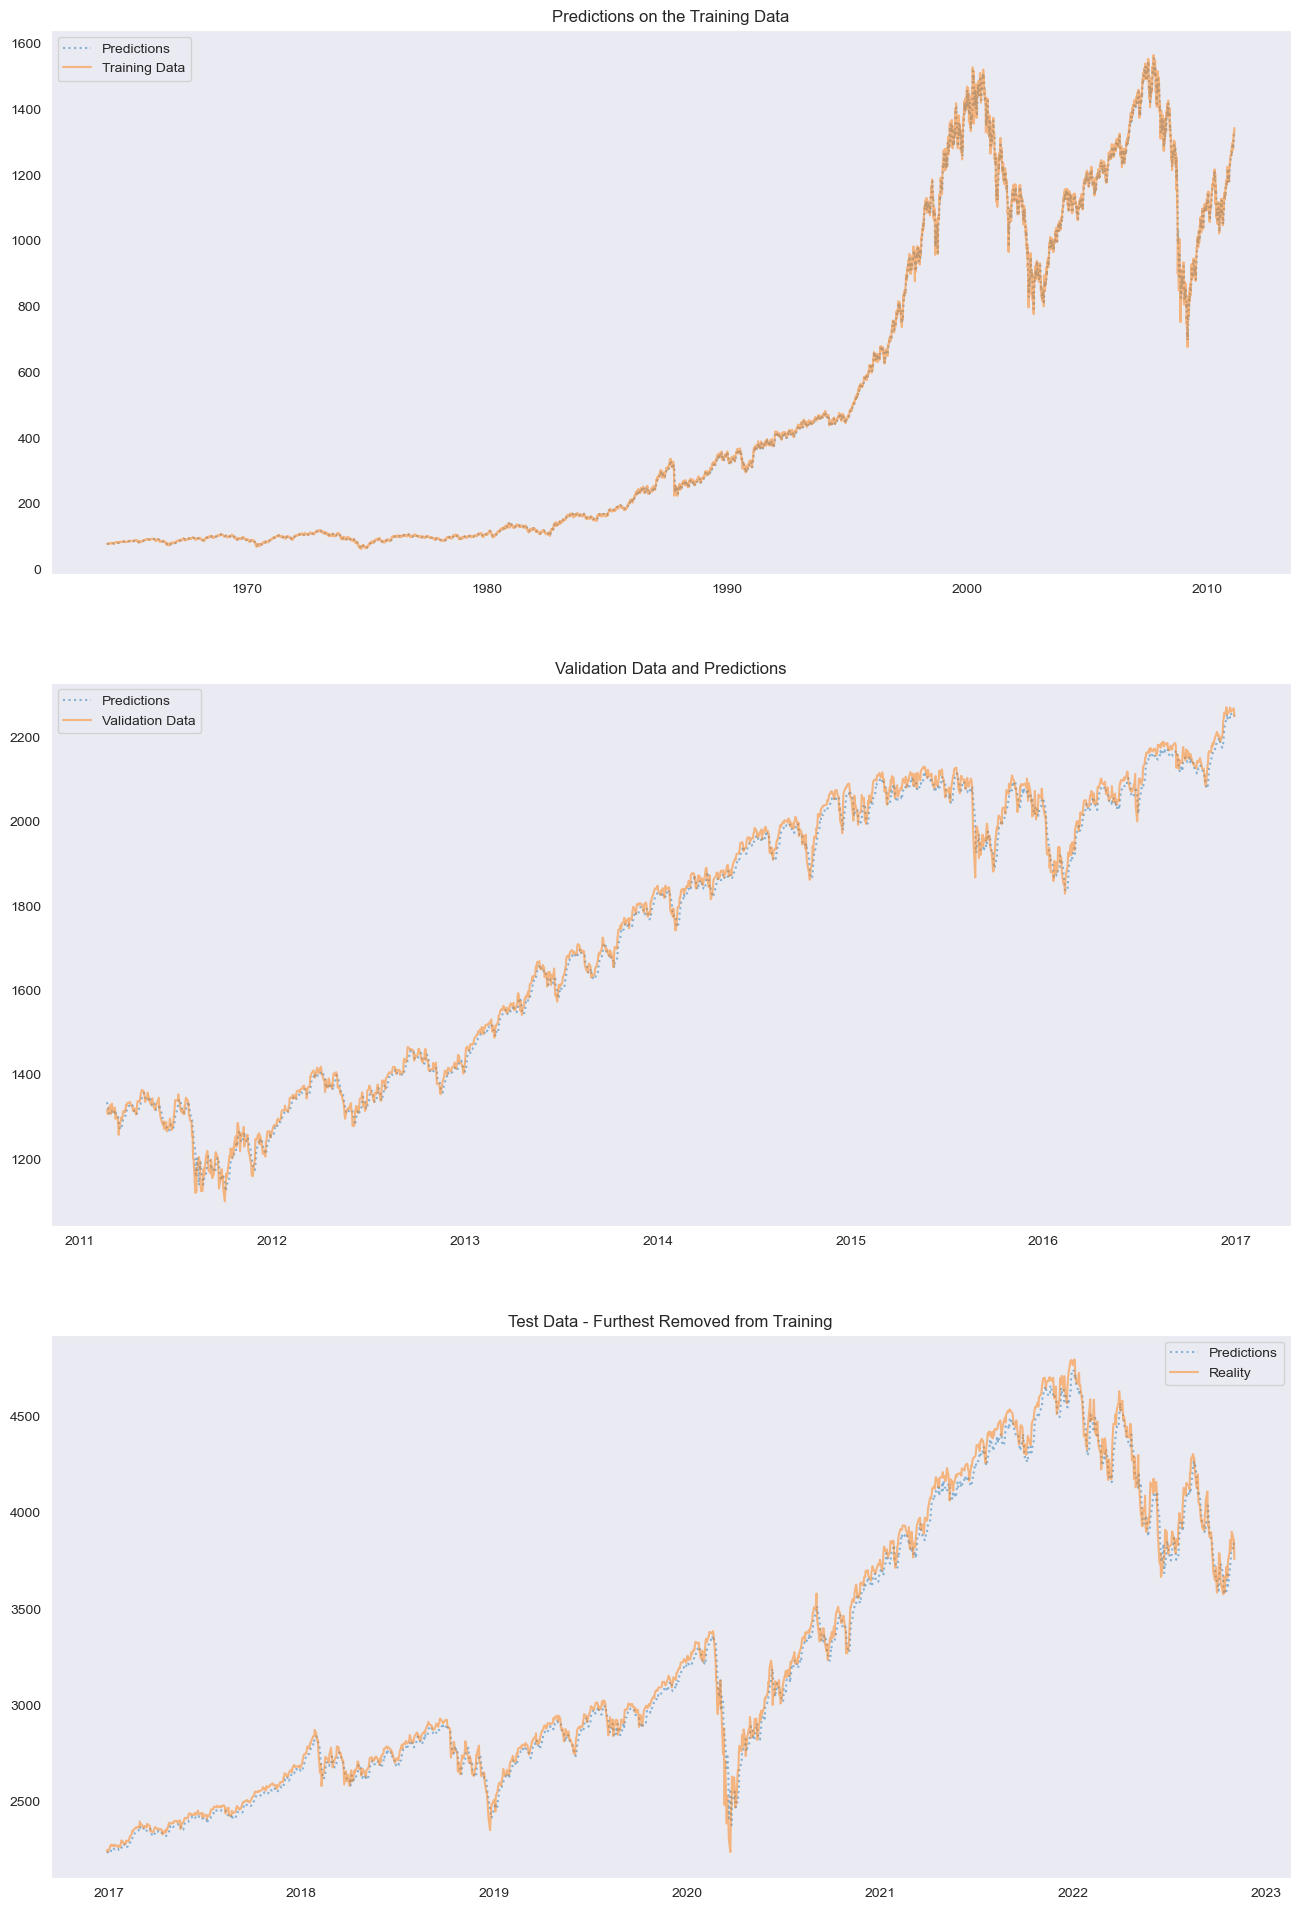

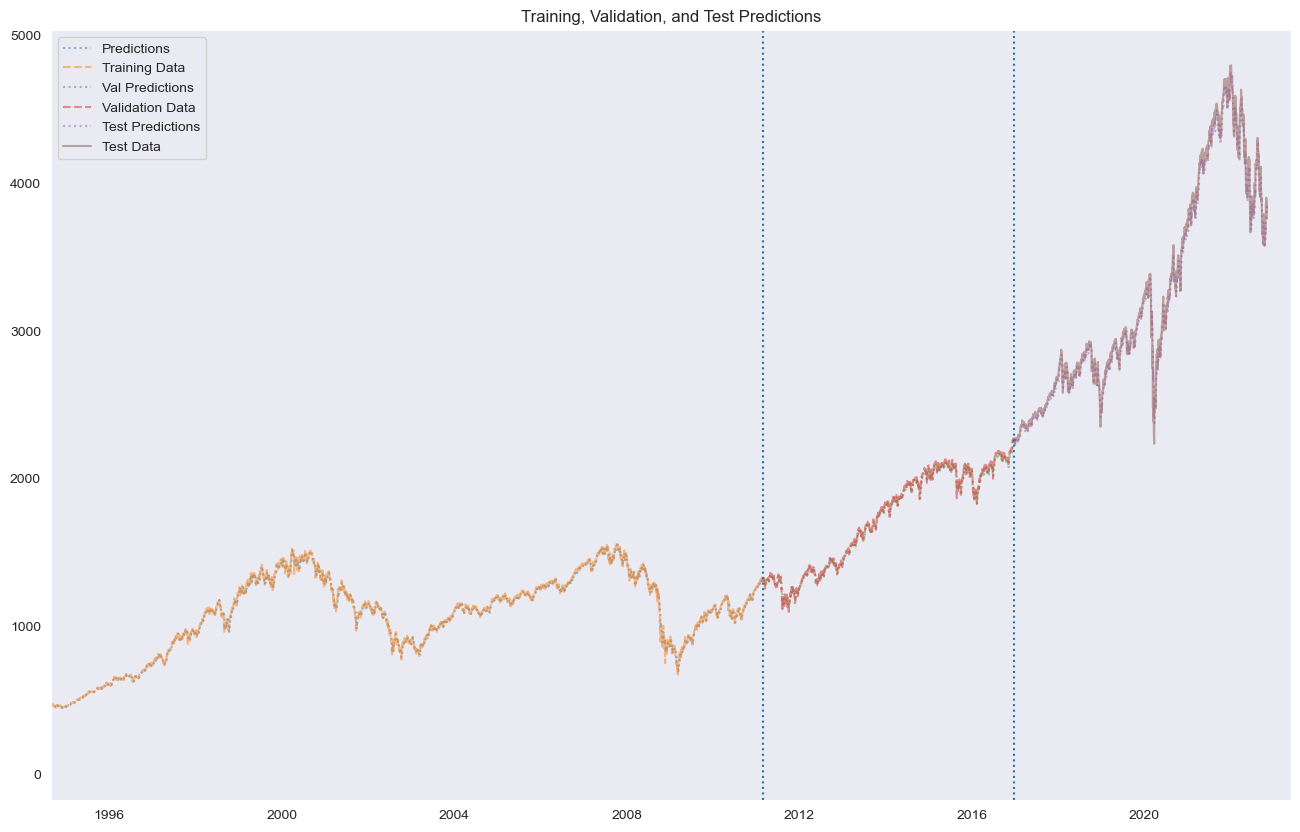

In [375]:
# Plotting the model
plot_results(model3)

In [376]:
test_metric_check(model3)

46/46 [==============================] - 0s 4ms/step
RMSE: 60.004186140539595 MAE: 46.14701674183482 R-Squared: 0.9930371285470185


### Evaluation
By adding early stopping, we didn't even get to 100 epochs of training, so I think that I will repeat this process once more, and allow the model to over-fit repeatedly, simply for the sake of improving the potential performance slightly. That being said, this model managed to achieve an R-squared of 99.3% variance explained by the model, very very impressive. 

### Removing Early Stopping

In [355]:
# Define the model4

# Sequential type
model4 = Sequential()

# LSTM Layer
model4.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(15, 1)))

# 2nd/Stacked LSTM Layer
model4.add(LSTM(50, activation='relu'))

# Dense Output Layer
model4.add(Dense(1))

# Compile the model4
model4.compile(optimizer='adam', loss='mse')

# Fit it to the data
model4.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=tensorboard_callback, epochs=100, batch_size=50)

Epoch 1/100
234/234 [==============================] - 6s 17ms/step - loss: 4214.9673 - val_loss: 534.4435
Epoch 2/100
234/234 [==============================] - 4s 16ms/step - loss: 187.9564 - val_loss: 578.2095
Epoch 3/100
234/234 [==============================] - 4s 15ms/step - loss: 175.4548 - val_loss: 607.2137
Epoch 4/100
234/234 [==============================] - 3s 15ms/step - loss: 188.9160 - val_loss: 548.0045
Epoch 5/100
234/234 [==============================] - 3s 15ms/step - loss: 3690.3987 - val_loss: 24324.5391
Epoch 6/100
234/234 [==============================] - 4s 15ms/step - loss: 280.4847 - val_loss: 540.8784
Epoch 7/100
234/234 [==============================] - 4s 15ms/step - loss: 182.9192 - val_loss: 598.0062
Epoch 8/100
234/234 [==============================] - 3s 15ms/step - loss: 169.3373 - val_loss: 575.9426
Epoch 9/100
234/234 [==============================] - 4s 15ms/step - loss: 155.3666 - val_loss: 481.3014
Epoch 10/100
234/234 [====================

234/234 [==============================] - 3s 15ms/step - loss: 84.2867 - val_loss: 410.1902
Epoch 78/100
234/234 [==============================] - 4s 15ms/step - loss: 96.0858 - val_loss: 289.7247
Epoch 79/100
234/234 [==============================] - 4s 16ms/step - loss: 107.3125 - val_loss: 630.9137
Epoch 80/100
234/234 [==============================] - 3s 15ms/step - loss: 102.3723 - val_loss: 380.5814
Epoch 81/100
234/234 [==============================] - 3s 14ms/step - loss: 87.8895 - val_loss: 280.8515
Epoch 82/100
234/234 [==============================] - 3s 14ms/step - loss: 94.6337 - val_loss: 276.9236
Epoch 83/100
234/234 [==============================] - 3s 14ms/step - loss: 100.3961 - val_loss: 413.3511
Epoch 84/100
234/234 [==============================] - 3s 14ms/step - loss: 89.9687 - val_loss: 912.4850
Epoch 85/100
234/234 [==============================] - 3s 14ms/step - loss: 93.9889 - val_loss: 272.4181
Epoch 86/100
234/234 [==============================] - 

In [356]:
aggregate_model_stats("Stacked LSTM 100 Eps", model4)
metric_df

46/46 [==============================] - 0s 4ms/step


,Name,Train MAE,Train MSE,Train RMSE,Train MAPE,Train R^2,Val MAE,Val MSE,Val RMSE,Val MAPE,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,First LSTM,14.655849,692.004735,26.305983,0.029581,0.996893,331.236827,175497.967750,418.924776,0.168680,-0.619916,1756.586200,3.592956e+06,1895.509464,0.517191,-5.948278
1,Stacked LSTM,6.905430,122.596246,11.072319,0.020250,0.999449,31.027961,1480.781290,38.480921,0.017092,0.986332,142.726357,2.498669e+04,158.071773,0.042615,0.951679
2,Stacked LSTM w Early Stopping,5.842786,109.315101,10.455386,0.013031,0.999509,17.368524,471.731029,21.719370,0.010204,0.995646,46.147017,3.600502e+03,60.004186,0.013905,0.993037
3,Stacked LSTM 100 Eps,4.818713,83.761252,9.152117,0.010159,0.999624,13.060235,318.033593,17.833496,0.007807,0.997064,28.575906,1.883054e+03,43.394176,0.008668,0.996358


46/46 [==============================] - 0s 4ms/step


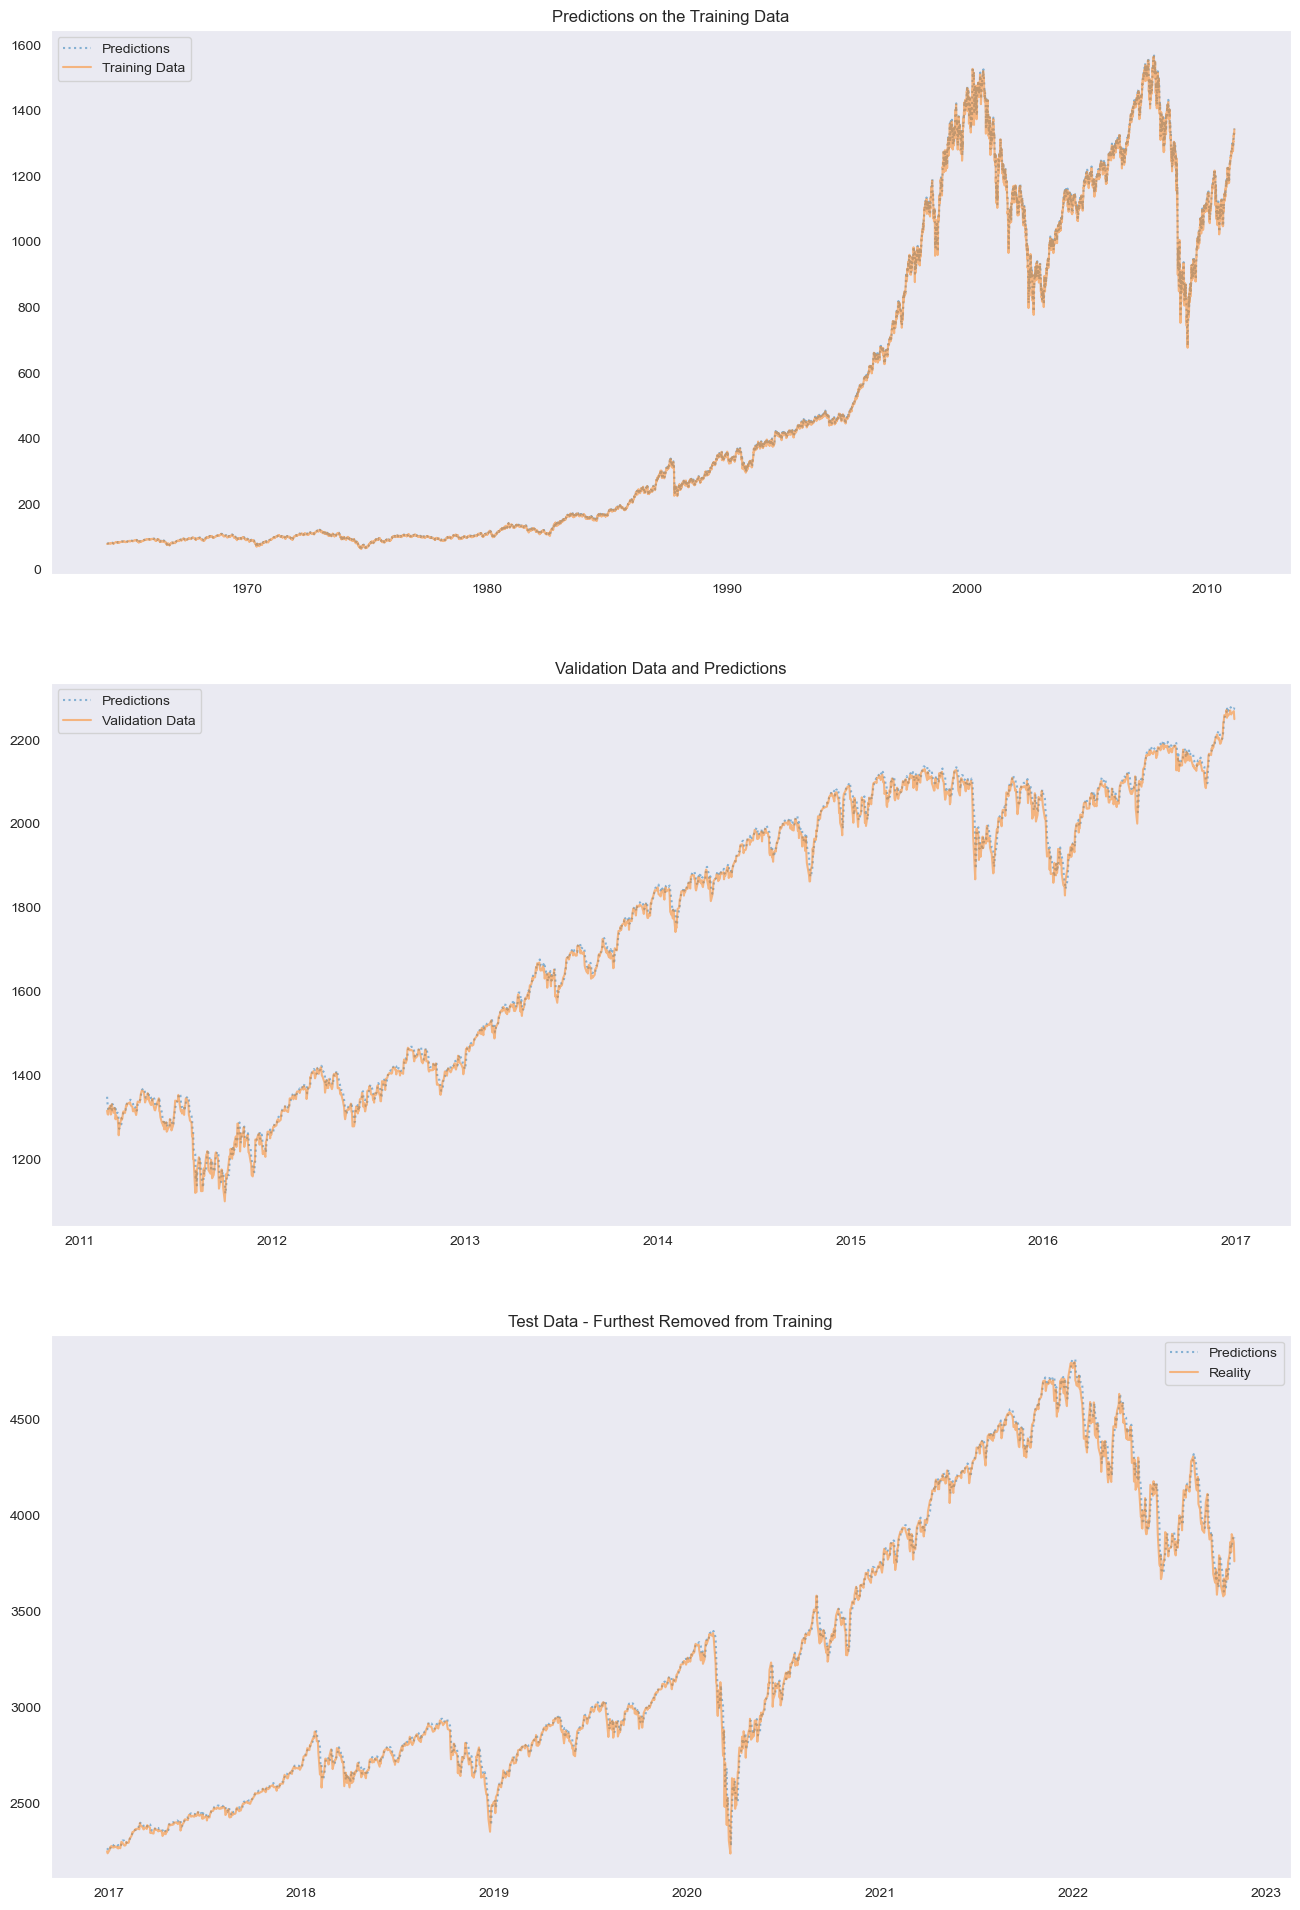

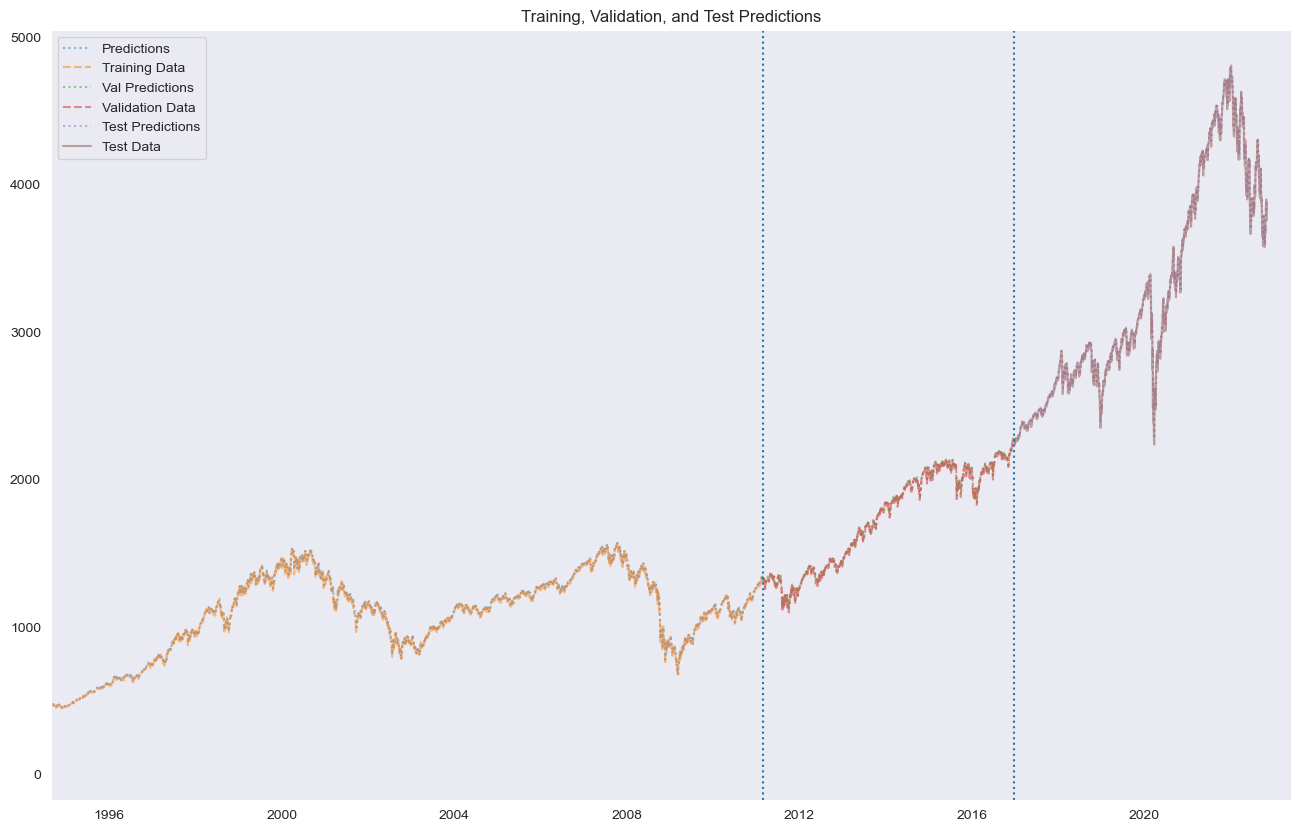

In [377]:
# Plotting the results of the model
plot_results(model4)

In [378]:
test_metric_check(model4, y_test, X_test)

46/46 [==============================] - 0s 4ms/step
RMSE: 43.394175577260164 MAE: 28.575906359546 R-Squared: 0.9963584341985912


### Evaluation
Once again, exemplary results. Slight improvements once again in all metrics.

<hr style="border: 2px solid blue">

### Extreme Stacked Model
While excellent metrics have been achieved, I will now attempt to build a more complicated model still, in hopes that we can somehow overfit the data, or achieve some semblance of having "gone too far". This model will feature an additional LSTM layer and still feature 100 epochs of training. 

In [381]:
# Define the model4

# Sequential type
model5 = Sequential()

# LSTM Layer
model5.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(15, 1)))

# 2nd/Stacked LSTM Layer
model5.add(LSTM(50, activation='relu', return_sequences=True))

# 3rd LSTM Layer
model5.add(LSTM(25, activation="relu"))

# Dense Output Layer
model5.add(Dense(1))

# Compile the model4
model5.compile(optimizer='adam', loss='mse')

# Fit it to the data
model5.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=tensorboard_callback, epochs=100, batch_size=50)

Epoch 1/100
234/234 [==============================] - 9s 25ms/step - loss: 64847.7617 - val_loss: 8338.6445
Epoch 2/100
234/234 [==============================] - 5s 22ms/step - loss: 28445.5000 - val_loss: 1368.9866
Epoch 3/100
234/234 [==============================] - 5s 23ms/step - loss: 29519.4102 - val_loss: 443.1545
Epoch 4/100
234/234 [==============================] - 5s 23ms/step - loss: 152.5408 - val_loss: 421.8039
Epoch 5/100
234/234 [==============================] - 6s 24ms/step - loss: 128.9041 - val_loss: 398.8728
Epoch 6/100
234/234 [==============================] - 6s 24ms/step - loss: 125.8903 - val_loss: 399.8409
Epoch 7/100
234/234 [==============================] - 5s 23ms/step - loss: 124.0301 - val_loss: 408.1920
Epoch 8/100
234/234 [==============================] - 5s 22ms/step - loss: 121.2343 - val_loss: 434.7083
Epoch 9/100
234/234 [==============================] - 5s 23ms/step - loss: 122.7244 - val_loss: 440.6868
Epoch 10/100
234/234 [================

234/234 [==============================] - 5s 20ms/step - loss: 181.5847 - val_loss: 739.3161
Epoch 78/100
234/234 [==============================] - 5s 20ms/step - loss: 175.2282 - val_loss: 847.7534
Epoch 79/100
234/234 [==============================] - 5s 20ms/step - loss: 188.0776 - val_loss: 545.4744
Epoch 80/100
234/234 [==============================] - 5s 21ms/step - loss: 172.4301 - val_loss: 648.1971
Epoch 81/100
234/234 [==============================] - 5s 20ms/step - loss: 204.3334 - val_loss: 672.8320
Epoch 82/100
234/234 [==============================] - 5s 20ms/step - loss: 181.9463 - val_loss: 3871.2686
Epoch 83/100
234/234 [==============================] - 4s 19ms/step - loss: 181.9994 - val_loss: 1292.2565
Epoch 84/100
234/234 [==============================] - 5s 20ms/step - loss: 216.0627 - val_loss: 596.1616
Epoch 85/100
234/234 [==============================] - 5s 19ms/step - loss: 160.6271 - val_loss: 1341.7255
Epoch 86/100
234/234 [=========================

In [382]:
aggregate_model_stats("3 LSTMs 100 Eps", model5)
metric_df

46/46 [==============================] - 0s 5ms/step


,Name,Train MAE,Train MSE,Train RMSE,Train MAPE,Train R^2,Val MAE,Val MSE,Val RMSE,Val MAPE,Val R^2,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,First LSTM,14.655849,692.004735,26.305983,0.029581,0.996893,331.236827,175497.967750,418.924776,0.168680,-0.619916,1756.586200,3.592956e+06,1895.509464,0.517191,-5.948278
1,Stacked LSTM,6.905430,122.596246,11.072319,0.020250,0.999449,31.027961,1480.781290,38.480921,0.017092,0.986332,142.726357,2.498669e+04,158.071773,0.042615,0.951679
2,Stacked LSTM w Early Stopping,5.842786,109.315101,10.455386,0.013031,0.999509,17.368524,471.731029,21.719370,0.010204,0.995646,46.147017,3.600502e+03,60.004186,0.013905,0.993037
3,Stacked LSTM 100 Eps,4.818713,83.761252,9.152117,0.010159,0.999624,13.060235,318.033593,17.833496,0.007807,0.997064,28.575906,1.883054e+03,43.394176,0.008668,0.996358
4,3 LSTMs 100 Eps,5.357101,101.145841,10.057129,0.010692,0.999546,16.084212,417.671819,20.437021,0.009526,0.996145,39.295940,2.924204e+03,54.075909,0.011852,0.994345


46/46 [==============================] - 0s 5ms/step


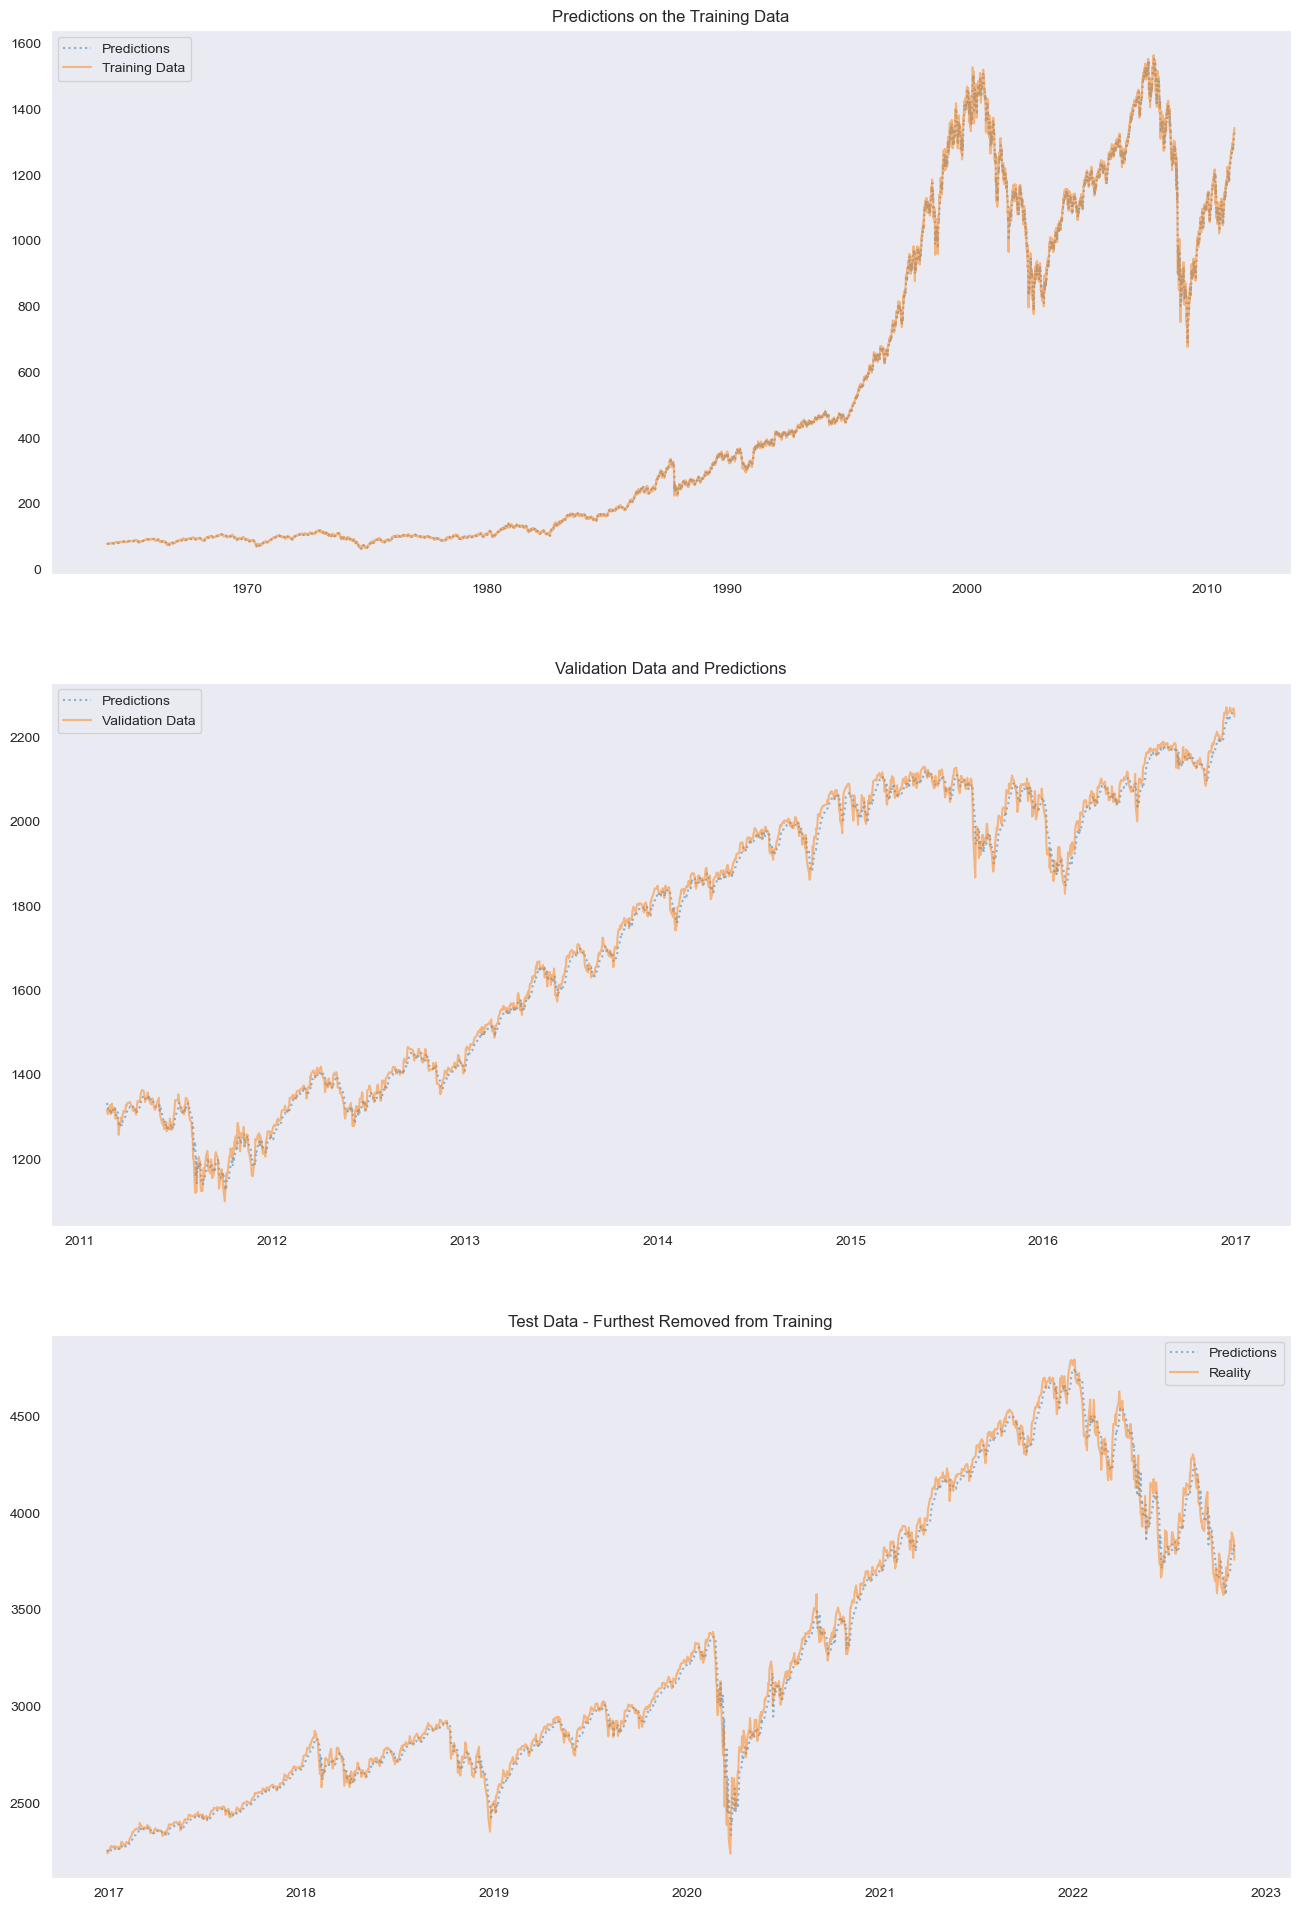

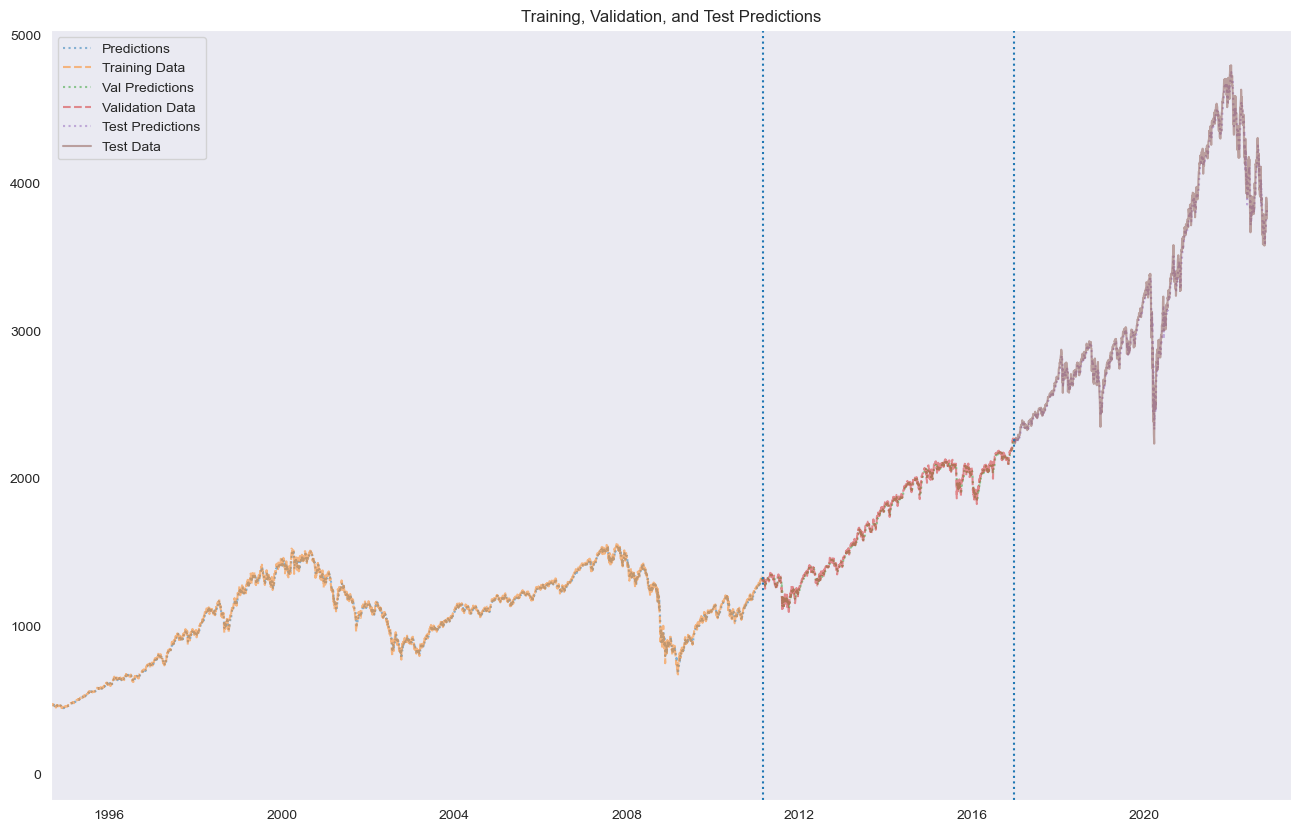

In [383]:
# Plotting the results of the model
plot_results(model5)

In [384]:
test_metric_check(model5)

46/46 [==============================] - 0s 6ms/step
RMSE: 54.07590852455321 MAE: 39.29594001822204 R-Squared: 0.9943449958550586


### Evaluation
This model, in spite of its additional complexity, has not yielded any improvement in results. An R^2 of 99.4% explained variance is still very very high. The key takeways from this experiment is that 15 days worth of data seems to be more than adequate in order for the LSTM to predict future values of the S&P. While the timing and exact values of key moves may not be perfectly synchronized, this model does seem more than capable of identifying levels of interest to pay attention to in the market.

In [391]:
# Showing final test metrics
metric_df[["Test MAE", "Test MSE", "Test RMSE", "Test MAPE", "Test R^2"]]

,Test MAE,Test MSE,Test RMSE,Test MAPE,Test R^2
0,1756.586200,3.592956e+06,1895.509464,0.517191,-5.948278
1,142.726357,2.498669e+04,158.071773,0.042615,0.951679
2,46.147017,3.600502e+03,60.004186,0.013905,0.993037
3,28.575906,1.883054e+03,43.394176,0.008668,0.996358
4,39.295940,2.924204e+03,54.075909,0.011852,0.994345
